# Experiments

This notebook outlines some experiments that were performed to analyse and validate the GLRM model. 

GLRM, in the unsupervised setting allows a user to run PCA, Sparse PCA and Non Negative Matrix Factorization. To test the validity of the implementation, I constructed a synthetic dataset as described in section 7.5 of the paper. The results of this test can be viewed below.

Following this, I chose two multivariate datsets from the UCI repository, the Statlog (Heart) Disease dataset and a Credit Card Default Dataset. the datsets comprised 13 and 24 features respectively. 

To test the models performance over a range of low rank representations, the percentage of features to test over was treated as a hyperparameter.Lambda was also treated the same way. Thus, GLRM can be used for a user-specified rank, but also find the most suitable rank, model-type and penalty value for a particular dataset. The results of these experiments can be seen below. 

GLRM can also be used to run a least squares regression. To test the implementation, I utilized a subset of the Boston Housing dataset, and compared the performance of my model with that of the linear model provided by Sklearn. 

In [135]:
import pandas as pd
import plotnine as gg

In [136]:
def add_frac(d):
    d['iteration_fraction'] = d.iteration / d.iteration.max()
    return d

##  Synthetic low-rank dataset

To test the validity of the model, a dataset from the paper is utilized. In section 7.4 of the paper, the authors explore convergence properties via a quadratically regularized PCA problem with randomly generated, fully observed data $A$ = $X^{true}$  $Y^{true}$, 
where the entries of
$X^{true}$ and $Y^{true}$ are drawn from a standard normal distribution. 

The examples are fit using PCA, Sparse PCA and NMF as described above. The curves displayed are for rank 2 (as described in the paper) well as 20, 40, 100 and 200. The original matrix $A$ has shape n = m = 200. 3000 iterations were used to fit the datset. 

Note* For NMF it is important to realise that the original synthetic data matrix A is composed of both positive and negative values. Thus, we can see (and is stated in the paper) that the convergence properties are different from PCA and Sparse PCA.

In [114]:
with open('results/results-synthetic_regular.csv') as f:
    synthetic_df = pd.read_csv(f)

synthetic_df = synthetic_df.groupby(['model', 'rank', 'lambd']).apply(add_frac).reset_index(drop=True)
synthetic_df['rank'] = synthetic_df['rank'].astype('category')
synthetic_df= synthetic_df[synthetic_df.lambd.isin([0,3])]
synthetic_df= synthetic_df[synthetic_df.iteration_fraction <= 1]

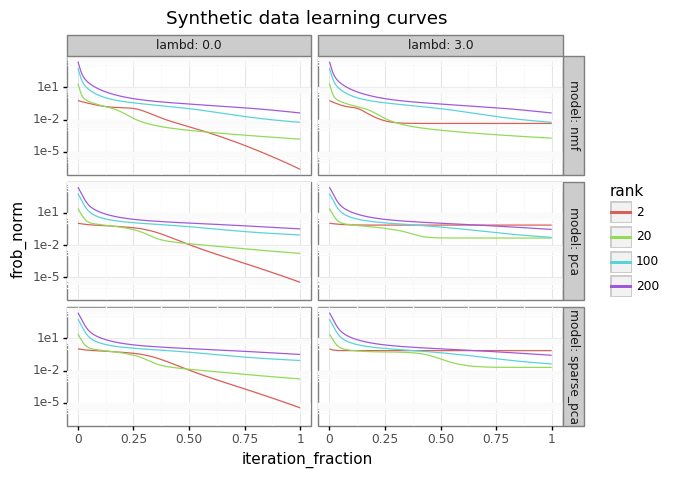

<ggplot: (332802189)>

In [120]:
plot = (
    gg.ggplot(synthetic_df)
    + gg.aes(x='iteration_fraction', y='frob_norm', color='rank')
    + gg.facet_grid(['model', 'lambd'], labeller='label_both')
    + gg.geom_line()
    + gg.theme(figure_size=(16, 12))
    + gg.theme_bw()
    + gg.scale_y_log10()
    + gg.ggtitle('Synthetic data learning curves')
)
plot

The experiments above show an interesting phenomenon --- the model that only uses the true rank (in this case $k=2$) results in a much better fit than for higher-rank models. 

In [116]:
rank = 20
lambd = 3
plot_df = synthetic_df[(synthetic_df['rank'] == rank) & (synthetic_df.lambd == lambd)]
# plot_df = plot_df.groupby('model').apply(lambda d: d[d.iteration == d.iteration.max()]).reset_index(drop=True)
plot_df = plot_df.groupby('model').apply(add_frac).reset_index()

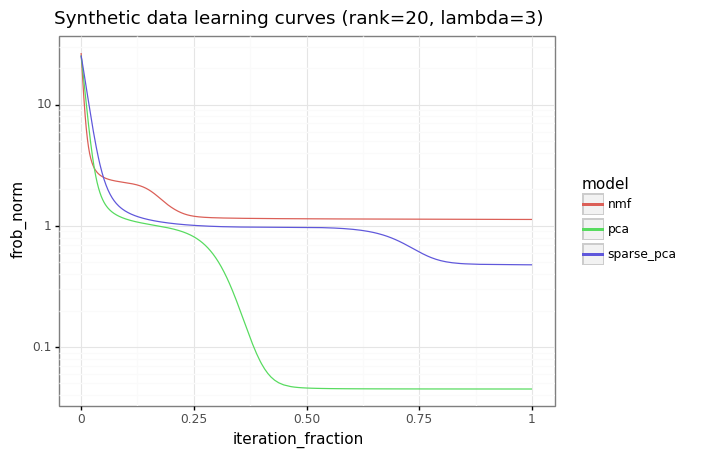

<ggplot: (334630221)>

In [121]:
plot = (
    gg.ggplot(plot_df)
    + gg.aes(x='iteration_fraction', y='frob_norm', color='model')
    # + gg.geom_point(alpha=0.5)
    + gg.geom_line()
    + gg.theme(figure_size=(16, 12))
    + gg.theme_bw()
    + gg.scale_y_log10()
    + gg.ggtitle(f'Synthetic data learning curves (rank={rank}, lambda={lambd})')
)
plot

To test NMF on an original data matrix consisting of positive values, I regenerated the synthetic dataset contraining it to positive values. 

In [118]:
with open('results/results-synthetic_nonnegative.csv') as f:
    synthetic_df = pd.read_csv(f)

synthetic_df = synthetic_df.groupby(['model', 'rank', 'lambd']).apply(add_frac).reset_index(drop=True)
synthetic_df['rank'] = synthetic_df['rank'].astype('category')
synthetic_df= synthetic_df[synthetic_df.lambd.isin([0,3])]
synthetic_df= synthetic_df[synthetic_df.iteration_fraction <= 1]

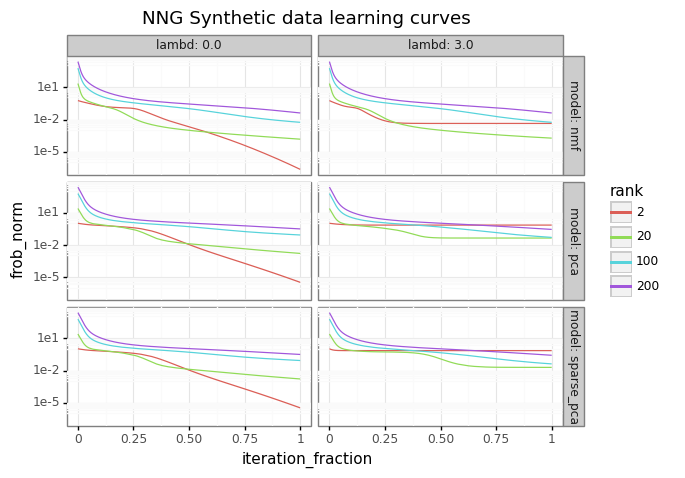

<ggplot: (357552457)>

In [122]:
plot = (
    gg.ggplot(synthetic_df)
    + gg.aes(x='iteration_fraction', y='frob_norm', color='rank')
    + gg.facet_grid(['model', 'lambd'], labeller='label_both')
    + gg.geom_line()
    + gg.theme(figure_size=(16, 12))
    + gg.theme_bw()
    + gg.scale_y_log10()
    + gg.ggtitle('NNG Synthetic data learning curves')
)
plot

With lambd = 0, one can see that NMF performs the best. This makes sense as the input data restriced to be >= 0.

## Statlog Heart Dataset
The dataset contains information with respect to factors that may result in heart disease. The dataset consists of 13 real-valued and integer features. 
3000 iterations were used to fit the dataset.

In [24]:
path = "../GLRM/data/statlog.csv"
df = pd.read_csv(path)
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,presence
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,1.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,1.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,1.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,1.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,2.000000


In [137]:
with open('results/results-statlog.csv') as f:
    statslog_df = pd.read_csv(f)

statslog_df['rank'] = statslog_df['rank'].astype('category')

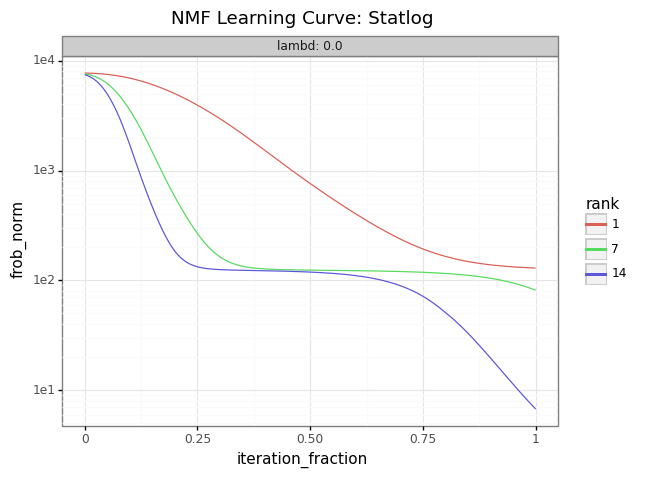

<ggplot: (334612109)>

In [141]:
plot_df = statslog_df.groupby(['rank', 'model', 'lambd']).apply(add_frac).reset_index()

plot = (
    gg.ggplot(plot_df[(plot_df.model == 'nmf') & (plot_df.lambd == 0.0)])
    + gg.aes(x='iteration_fraction', y='frob_norm', color='rank')
    + gg.facet_wrap('lambd', labeller='label_both', ncol=5)
    + gg.geom_line()
    + gg.theme(figure_size=(16, 12))
    + gg.theme_bw()
    + gg.scale_y_log10()
    + gg.ggtitle('NMF Learning Curve: Statlog')
)
plot

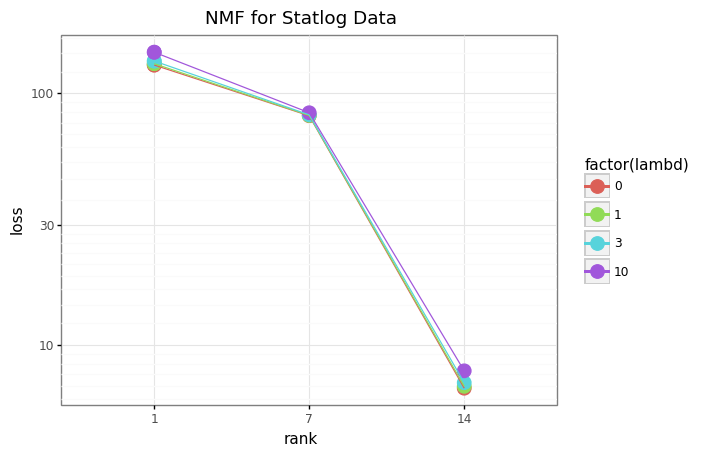

<ggplot: (331768797)>

In [129]:
plot_df = statslog_df.groupby(['rank', 'model', 'lambd']).apply(add_frac).reset_index()
plot_df = plot_df[plot_df.model == 'nmf']
plot_df = plot_df[plot_df.iteration_fraction == 1]

plot = (
    gg.ggplot(plot_df)
    + gg.aes(x='rank', y='loss', color='factor(lambd)', group='factor(lambd)')
    # + gg.facet_wrap('lambd', labeller='label_both', ncol=5)
    + gg.geom_point(size=5)
    + gg.geom_line()
    + gg.theme(figure_size=(16, 12))
    + gg.theme_bw()
    + gg.scale_y_log10()
    + gg.ggtitle('NMF for Statlog Data')
)
plot

When it is either very easy (rank = 14) or very hard(rank =1) for the model to approximate a low rank matrix, adding regularization does not seem to make a difference. Approximating a model of rank 7 however, does display the affect of lambda.

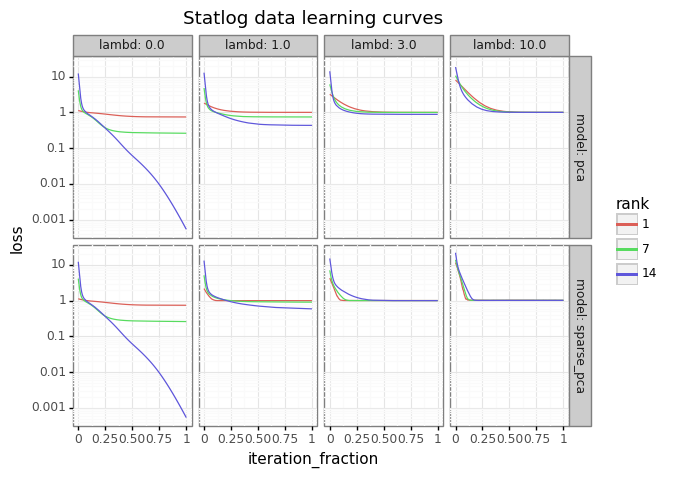

<ggplot: (287332161)>

In [146]:
plot_df = statslog_df.groupby(['rank', 'model', 'lambd']).apply(add_frac).reset_index()

plot = (
    gg.ggplot(plot_df[plot_df.model != 'nmf'])
    + gg.aes(x='iteration_fraction', y='loss', color='rank')
    + gg.facet_grid(['model', 'lambd'], labeller='label_both')
    + gg.geom_line()
    + gg.theme(figure_size=(16, 12))
    + gg.theme_bw()
    + gg.scale_y_log10()
    + gg.ggtitle('Statlog data learning curves')
)
plot

The performance of Sparse PCA and PCA are similar, and adding regularization does not significantly increase performance. It is interesting to see, however, that adding significant shrinkage diminishes even initial performance. PCA and Sparse PCA did however perform much better on average than NMF on this dataset. 

## Default of Credit Card Clients Dataset


This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. 25 features are included in the dataset, out of which 24 were considered (not including ID of each client). 
5000 iterations were used to fit the dataset.

In [189]:
path = "../GLRM/data/UCI_Credit_Card.csv"
credit_dataset = pd.read_csv(path)
credit_dataset = credit_dataset.drop('ID', axis=1)
credit_dataset.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [147]:
with open('results/results-credit_card.csv') as f:
    credit_df = pd.read_csv(f)

credit_df['rank'] = credit_df['rank'].astype('category')
credit_df = credit_df.groupby(['rank', 'model', 'lambd']).apply(add_frac).reset_index()

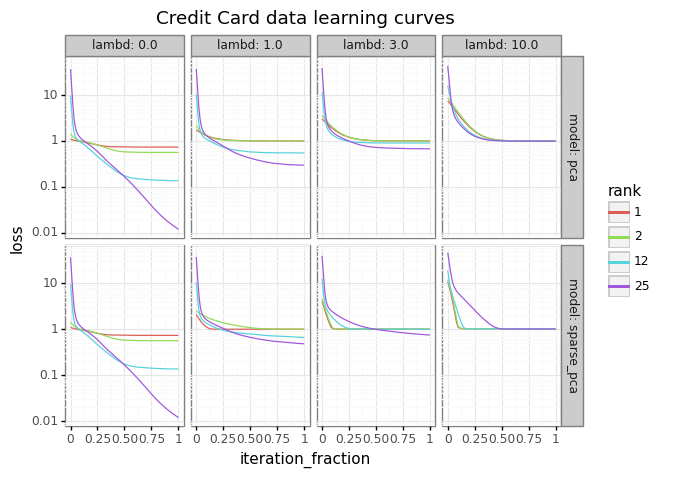

<ggplot: (335279921)>

In [148]:
plot_df = credit_df.groupby(['rank', 'model', 'lambd']).apply(add_frac).reset_index()

plot = (
    gg.ggplot(plot_df[plot_df.model != 'nmf']) 
    + gg.aes(x='iteration_fraction', y='loss', color='rank')
    + gg.facet_grid(['model', 'lambd'], labeller='label_both')
    + gg.geom_line()
    + gg.theme(figure_size=(16, 12))
    + gg.theme_bw()
    + gg.scale_y_log10()
    + gg.ggtitle('Credit Card data learning curves')
)
plot

It is interesting to see from the above plots that increasing the regularizer decreases the ability of the model to fit the data (see: rank 12). In general, this data is hard to reduce to a lower rank representation. Sparse PCA and PCA perform compartively better than NMF.

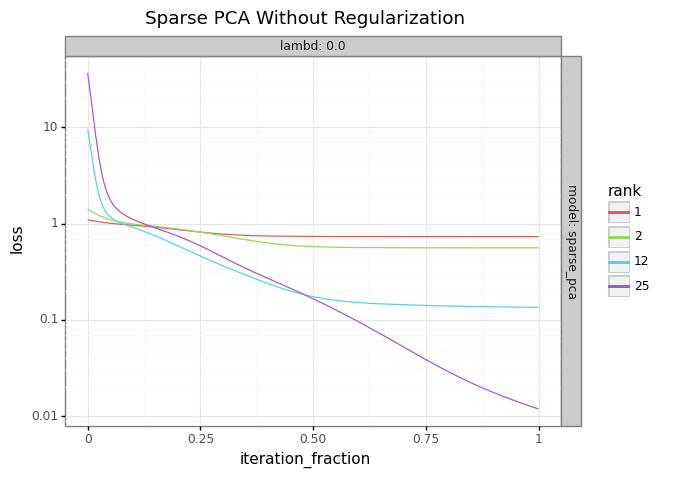

<ggplot: (342353773)>

In [134]:
plot_df = credit_df.groupby(['rank', 'model', 'lambd']).apply(add_frac).reset_index()

plot = (
    gg.ggplot(plot_df[(plot_df.model == 'sparse_pca') & (plot_df.lambd == 0.0)])
    + gg.aes(x='iteration_fraction', y='loss', color='rank')
    + gg.facet_grid(['model', 'lambd'], labeller='label_both')
    + gg.geom_line()
    + gg.theme(figure_size=(16, 12))
    + gg.theme_bw()
    + gg.scale_y_log10()
    + gg.ggtitle('Sparse PCA Without Regularization')
)
plot

It can be seen that for this dataset PCA performs better than Sparse PCA. The low rank of 12 (in the absence of ranks of similar value) is a comparitively better choice.

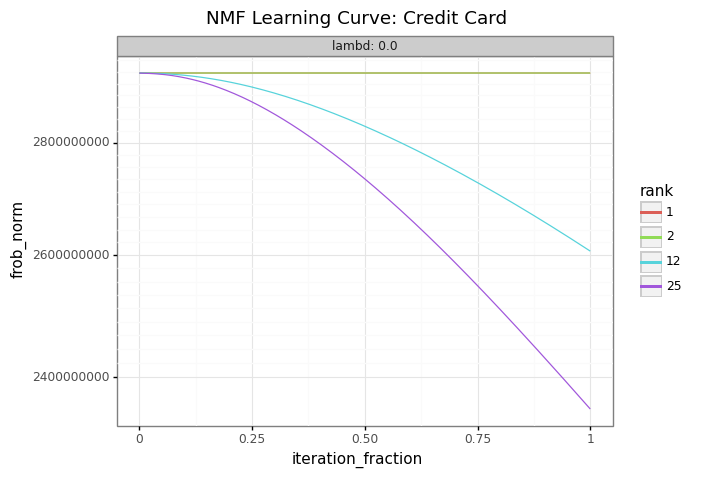

<ggplot: (345098965)>

In [150]:
plot_df = credit_df.groupby(['rank', 'model', 'lambd']).apply(add_frac).reset_index()

plot = (
    gg.ggplot(plot_df[(plot_df.model == 'nmf') & (plot_df.lambd == 0.0)])
    + gg.aes(x='iteration_fraction', y='frob_norm', color='rank')
    + gg.facet_wrap('lambd', labeller='label_both', ncol=5)
    + gg.geom_line()
    + gg.theme(figure_size=(16, 12))
    + gg.theme_bw()
    + gg.scale_y_log10()
    + gg.ggtitle('NMF Learning Curve: Credit Card')
)
plot

It is important to note the comparitive lack of performance from NMF on this dataset, as can be seen from the above plot.

## Housing Data (Supervised Learning)

A simple supervised learning experiment was performed on a subset of the Boston Housing dataset. The GLRM implementation utilizes Pytorch's linalg functionality and SVD. To compare the performance of this implementation with standard implementation, the same data is tested with Sklearn's Linear Regression model. MSE and R^2 for both are provided below. GLRM performs better than Sklearn's Linear Regression model. 

In [195]:
# Supervised learning experiment

with open('results/results-supervised.csv') as f:
    housing_df = pd.read_csv(f,index_col=0)

In [196]:
housing_df 

,algorithm,mse,r_squared
0,glrm,0.276103,0.690158
1,sklearn,1.448274,0.728158
